## Actor Critic Reinforcement Learning Method
https://keras.io/examples/rl/actor_critic_cartpole/

In [145]:
# Setup
import keras
import tensorflow as tf
from keras import layers
import numpy as np
from blackjack_env import BlackjackEnv
import matplotlib.pyplot as plt
import pandas as pd
import random

# Custom blackjack environment
env = BlackjackEnv()

# Configuration parameters for the whole setup
gamma = 0.99  # Discount factor for past rewards
num_inputs = 2 # Player hand value, Dealer's visible card
num_actions = 2 # Hit or stay
num_hidden1 = 64 # 8, 16, 32, 64, 128, 256
num_hidden2 = 64

# Set random seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [146]:
# Define the Actor-Critic Model

# Input
inputs = layers.Input(shape=(num_inputs,))

# Hidden
hidden1 = layers.Dense(num_hidden1, activation="relu")(inputs)
hidden2 = layers.Dense(num_hidden2, activation="relu")(hidden1)

# Actor
action = layers.Dense(num_actions, activation="softmax")(hidden2)

# Critic
critic = layers.Dense(1)(hidden2)

# Create model
model = keras.Model(inputs=inputs, outputs=[action, critic])
#####################################################################################
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#####################################################################################
#optimizer = keras.optimizers.Adam(learning_rate=0.005) # Different rates: 0.005, 0.001 , 0.0005, 0.0001
huber_loss = keras.losses.Huber()

In [147]:
# Training Loop
running_reward = 0
episode_count = 0
episode_rewards = [] # Track rewards for each episode

MAX_HANDS = 2000 # Stops after this many episodes

epsilon = 0.1 # Exploration factor
epsilon_min = 0.01
epsilon_decay = 0.995 # 0.999, 0.995, 0.99, 0.95

wins = 0
losses = 0
ties = 0

won = 0

# Track first and last losses
initial_actor_loss = None
initial_critic_loss = None
final_actor_loss = None
final_critic_loss = None

# Track actor and critic losses
actor_losses_history = []
critic_losses_history = []

for hand_count in range(MAX_HANDS):
    state = env.reset()
    episode_reward = 0
    action_probs_history, critic_value_history, rewards_history = [], [], []

    with tf.GradientTape() as tape:
        for _ in range(100):  # Play rounds
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)

            # Predict action probabilities and estimated future rewards
            action_probs, critic_value = model(state_tensor)
            critic_value_history.append(critic_value[0, 0])

            # Epsilon decay
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions) # Explore
            else:
                action = np.argmax(action_probs) # Exploit

            # Choose an action based on probabilities
            # action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the action in Blackjack
            state, reward, done, player_value, dealer_value = env.step(action)
            #####################################################################################
            if reward == 1:
                won = 1
            elif reward == -1:
                won = -1
            else:
                won = 0 
                           
            #if hand_count < 200 and reward == -1:
                #reward *= 1.1
            #if hand_count > 500 and reward == 1:
                #reward *= 1.1
            if player_value >= 17 and reward == 1:
                reward *= 1.1
            if player_value >= 22 and reward == -1:
                reward *= 1.1
            #####################################################################################        
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                if won == 1:
                    wins += 1
                elif won == -1:
                    losses += 1
                else:
                    ties += 1
                break # End episode

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in reversed(rewards_history):
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize returns
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-7)

        # Compute Loss
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses, critic_losses = [], []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up receiving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # Actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track losses for averaging after training
    actor_losses_history.append(np.mean(actor_losses))
    critic_losses_history.append(np.mean(critic_losses))

    # Initial losses at first iteration
    if initial_actor_loss is None and initial_critic_loss is None:
        initial_actor_loss = actor_losses_history[-1]
        initial_critic_loss = critic_losses_history[-1]

    # Store final losses every iteration
    final_actor_loss = actor_losses_history[-1]
    final_critic_loss = critic_losses_history[-1]

    # Store rewards
    episode_rewards.append(episode_reward)

    # Track performance
    running_reward += episode_reward
    #running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward # Higher value - model reacts faster to changes / Lower value - smoother trend but slower to update
    episode_count += 1

    if episode_count % 100 == 0 or episode_count == 1:
        print(f"Episode {hand_count + 1}: Episode Reward: {episode_reward:.2f}, Running Reward: {running_reward / episode_count:.2f}, Player Value: {player_value}, Dealer Value: {dealer_value}")

    if running_reward / episode_count > 5:  # Stop when the AI consistently wins
        print(f"Solved in {hand_count + 1} episodes!")
        break

# Display initial and final losses
print(f"Initial Actor Loss: {initial_actor_loss:.4f}")
print(f"Final Actor Loss: {final_actor_loss:.4f}")
print(f"Initial Critic Loss: {initial_critic_loss:.4f}")
print(f"Final Critic Loss: {final_critic_loss:.4f}")

# Display average loss after episodes complete
average_actor_loss = np.mean(actor_losses_history)
average_critic_loss = np.mean(critic_losses_history)

print(f"Average Actor Loss: {average_actor_loss:.4f}")
print(f"Average Critic Loss: {average_critic_loss:.4f}")

# Display average reward
average_reward = np.mean(episode_rewards)
print(f"Average Reward after {episode_count} episodes: {average_reward:.2f}")

# Displays wins/losses/ties
print(f"Total Wins: {wins}")
print(f"Total Losses: {losses}")
print(f"Total Ties: {ties}")

Episode 1: Episode Reward: -1.10, Running Reward: -1.10, Player Value: 24, Dealer Value: 9
Episode 100: Episode Reward: -1.00, Running Reward: -0.23, Player Value: 13, Dealer Value: 20
Episode 200: Episode Reward: 1.00, Running Reward: -0.18, Player Value: 15, Dealer Value: 26
Episode 300: Episode Reward: 1.10, Running Reward: -0.14, Player Value: 21, Dealer Value: 22
Episode 400: Episode Reward: -1.00, Running Reward: -0.16, Player Value: 14, Dealer Value: 20
Episode 500: Episode Reward: 1.10, Running Reward: -0.16, Player Value: 18, Dealer Value: 23
Episode 600: Episode Reward: 1.00, Running Reward: -0.16, Player Value: 16, Dealer Value: 26
Episode 700: Episode Reward: 1.00, Running Reward: -0.16, Player Value: 10, Dealer Value: 25
Episode 800: Episode Reward: 1.10, Running Reward: -0.15, Player Value: 18, Dealer Value: 23
Episode 900: Episode Reward: 1.10, Running Reward: -0.16, Player Value: 21, Dealer Value: 20
Episode 1000: Episode Reward: -1.00, Running Reward: -0.17, Player Val

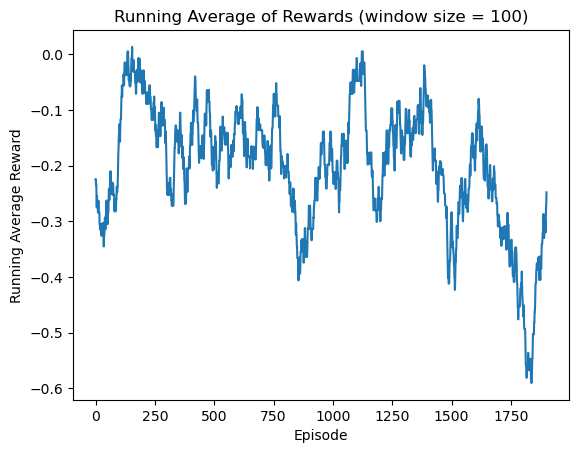

In [ ]:
# Average of rewards per episode
window_size = 100
running_avg_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(running_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Running Average Reward')
plt.title(f'Running Average of Rewards (window size = {window_size})')
#plt.savefig('Output/average_rewards.png')
plt.show()

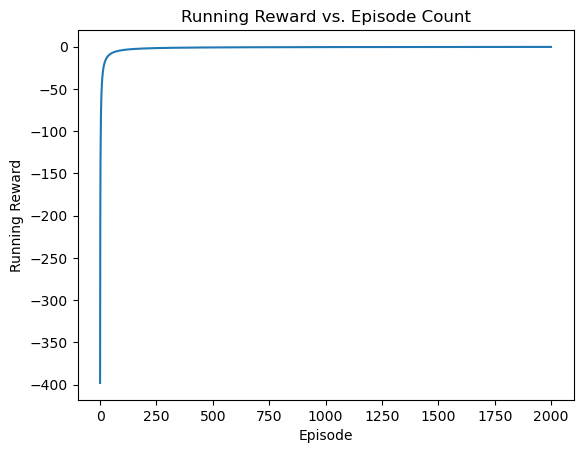

In [ ]:
# Plot Running Reward
plt.plot(range(episode_count), [running_reward / (i + 1) for i in range(episode_count)])
plt.xlabel('Episode')
plt.ylabel('Running Reward')
plt.title('Running Reward vs. Episode Count')
#plt.savefig('Output/running_reward.png')
plt.show()

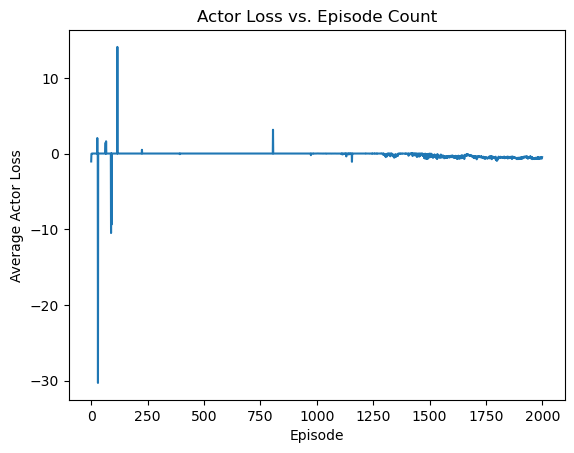

In [156]:
# Plot Actor Loss
plt.plot(range(episode_count), actor_losses_history)
plt.xlabel('Episode')
plt.ylabel('Average Actor Loss')
plt.title('Actor Loss vs. Episode Count')
plt.savefig('Output/actor_loss.png')
plt.show()

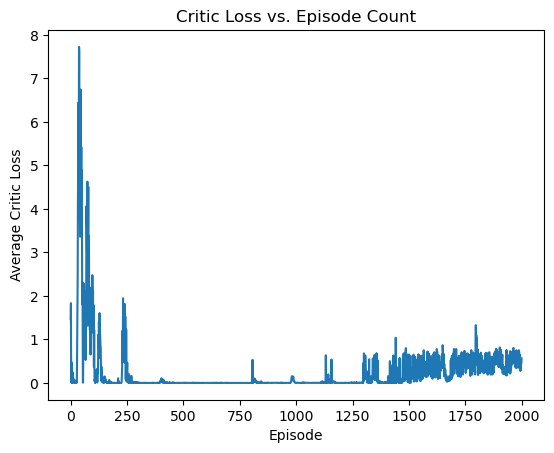

In [157]:
# Plot Critic Loss
plt.plot(range(episode_count), critic_losses_history)
plt.xlabel('Episode')
plt.ylabel('Average Critic Loss')
plt.title('Critic Loss vs. Episode Count')
plt.savefig('Output/critic_loss.png')
plt.show()

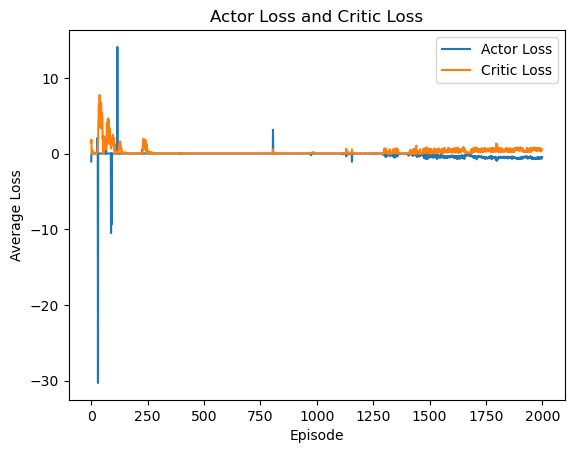

In [ ]:
plt.plot(actor_losses_history, label="Actor Loss")
plt.plot(critic_losses_history, label="Critic Loss")
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Actor Loss and Critic Loss')
#plt.savefig('Output/actor_critic_loss.png')
plt.show()

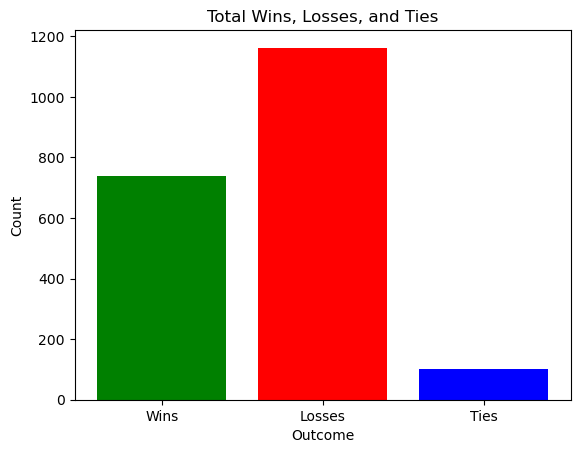

In [158]:
categories = ['Wins', 'Losses', 'Ties']
counts = [wins, losses, ties]
plt.bar(categories, counts, color=['green', 'red', 'blue'])
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Total Wins, Losses, and Ties')
plt.savefig('Output/outcomes.png')
plt.show()

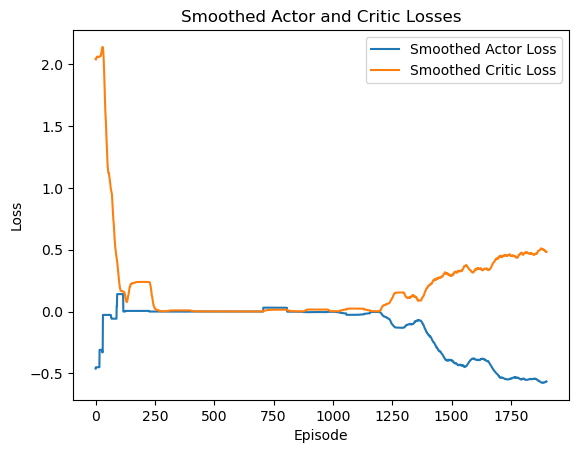

In [159]:
actor_losses_smooth = np.convolve(actor_losses_history, np.ones(window_size)/window_size, mode='valid')
critic_losses_smooth = np.convolve(critic_losses_history, np.ones(window_size)/window_size, mode='valid')

plt.plot(actor_losses_smooth, label='Smoothed Actor Loss')
plt.plot(critic_losses_smooth, label='Smoothed Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Smoothed Actor and Critic Losses')
plt.legend()
plt.savefig('Output/smoothed_losses.png')
plt.show()

In [ ]:
# Save the trained model
#model.save("Output/blackjack_model.h5")